<a href="https://colab.research.google.com/github/ParthTiwari246/NeuralNetworks/blob/main/NameGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import time
import matplotlib.pyplot as plt
plt.style.use('classic')

In [2]:
with open('/content/male.txt', 'r') as f:
  data = f.read()

In [3]:
#data visualising
print(f'Total Letters in the data : {len(data)}')
vocab = sorted(set(list(data[:10_000])))
vocab_length = len(vocab)
print('\n')
print('Vocabulary Length : ',vocab_length)

Total Letters in the data : 20293


Vocabulary Length :  42


In [4]:
vocab[:10]

['\n', '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [15]:
ids_from_chars = layers.StringLookup(vocabulary=vocab,
                                     mask_token=None)

chars_from_ids = layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(),
                                     invert=True,
                                     mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [16]:
names = data.splitlines()
names[:10]

['Aamir',
 'Aaron',
 'Abbey',
 'Abbie',
 'Abbot',
 'Abbott',
 'Abby',
 'Abdel',
 'Abdul',
 'Abdulkarim']

In [17]:
all_ids = ids_from_chars(tf.strings.unicode_split(names, 'UTF-8'))
all_ids[:10]

<tf.RaggedTensor [[3, 17, 29, 25, 34], [3, 17, 34, 31, 30], [3, 18, 18, 21, 41],
 [3, 18, 18, 25, 21], [3, 18, 18, 31, 36], [3, 18, 18, 31, 36, 36],
 [3, 18, 18, 41], [3, 18, 20, 21, 28], [3, 18, 20, 37, 28],
 [3, 18, 20, 37, 28, 27, 17, 34, 25, 29]]>

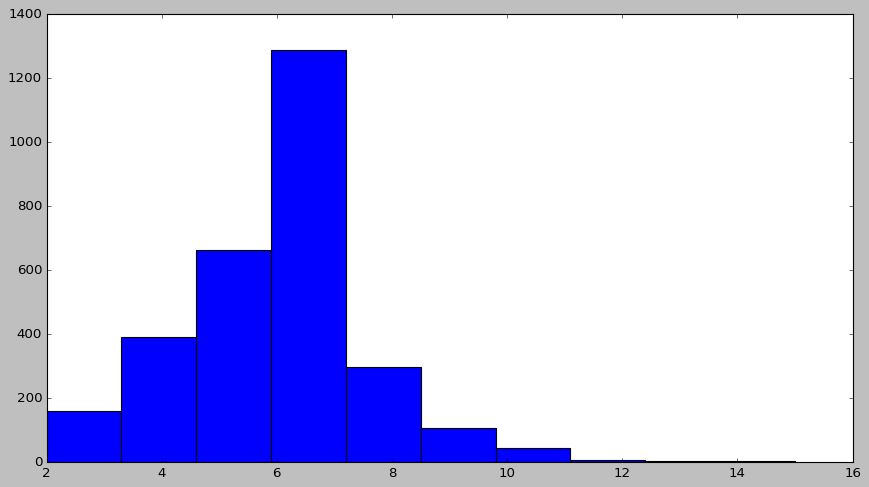



Maximum Length :  15


In [18]:
plt.figure(figsize=(13,7))
plt.hist([len(i) for i in all_ids])
plt.show()
max_length = max([len(i) for i in all_ids])
print('\n')
print('Maximum Length : ', max_length)

In [19]:
ids_dataset = []
for i in all_ids:
  ids_dataset.append(i)

ids_dataset = pad_sequences(ids_dataset,
                            maxlen=15,
                            padding='pre')

ids_dataset = tf.data.Dataset.from_tensor_slices(ids_dataset)

In [20]:
for ids in ids_dataset.take(1):
  print(chars_from_ids(ids).numpy())

[b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]' b'[UNK]'
 b'[UNK]' b'[UNK]' b'A' b'a' b'm' b'i' b'r']


In [21]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [22]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [23]:
for ids in ids_dataset.take(1):
  print(text_from_ids(ids).numpy())

b'[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]Aamir'


In [24]:
dataset = ids_dataset.map(split_input_target)

In [25]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]Aami'
Target: b'[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]Aamir'


In [26]:
dataset = dataset.shuffle(8_000).batch(32).prefetch(tf.data.AUTOTUNE)
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.int32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))>

In [27]:
vocab_size = len(ids_from_chars.get_vocabulary())

In [28]:
class MyModel(Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = layers.Embedding(vocab_size, embedding_dim)
    self.gru = layers.GRU(rnn_units,
                          return_sequences=True,
                          return_state=True)
    self.dense = layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [29]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    rnn_units=64)

In [30]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 14, 43) # (batch_size, sequence_length, vocab_size)


In [31]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  5504      
                                                                 
 gru (GRU)                   multiple                  37248     
                                                                 
 dense (Dense)               multiple                  2795      
                                                                 
Total params: 45,547
Trainable params: 45,547
Non-trainable params: 0
_________________________________________________________________


In [32]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [33]:
sampled_indices

array([ 6, 14, 10, 35, 29, 30,  3, 16, 32, 28,  5, 19, 22,  7])

In [34]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]Benj'

Next Char Predictions:
 b'DLHsmnAPplCcfE'


In [35]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [36]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (32, 14, 43)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(3.794983, shape=(), dtype=float32)


In [37]:
tf.exp(example_batch_mean_loss).numpy()

44.477474

In [38]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='loss',
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

In [39]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback, tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)])

Epoch 1/100
92/92 [==============================] - 3s 5ms/step - loss: 2.1571
Epoch 2/100
92/92 [==============================] - 1s 5ms/step - loss: 1.3129
Epoch 3/100
92/92 [==============================] - 1s 5ms/step - loss: 1.2010
Epoch 4/100
92/92 [==============================] - 1s 5ms/step - loss: 1.1711
Epoch 5/100
92/92 [==============================] - 1s 5ms/step - loss: 1.1467
Epoch 6/100
92/92 [==============================] - 1s 5ms/step - loss: 1.1315
Epoch 7/100
92/92 [==============================] - 1s 5ms/step - loss: 1.1181
Epoch 8/100
92/92 [==============================] - 1s 5ms/step - loss: 1.1059
Epoch 9/100
92/92 [==============================] - 1s 5ms/step - loss: 1.0951
Epoch 10/100
92/92 [==============================] - 1s 5ms/step - loss: 1.0863
Epoch 11/100
92/92 [==============================] - 1s 5ms/step - loss: 1.0780
Epoch 12/100
92/92 [==============================] - 1s 5ms/step - loss: 1.0706
Epoch 13/100
92/92 [=================

In [41]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [42]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [46]:
start = time.time()
states = None
next_char = tf.constant(['Adam'])
result = [next_char]

for n in range(7):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Adamandolph 

________________________________________________________________________________

Run time: 0.03851175308227539


In [47]:
start = time.time()
states = None
next_char = tf.constant(['andrew', 'marshall', 'margaret', 'jullian', 'jeniffer'])
result = [next_char]

for n in range(6):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b'andrewConton' b'marshallbastis' b'margarethnique' b'jullianPurPha'
 b'jenifferclahma'], shape=(5,), dtype=string) 

________________________________________________________________________________

Run time: 0.7176797389984131
